### Emotion Detection

In [1]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

Using TensorFlow backend.


In [10]:
num_classes = 6
img_rows = 64
img_cols = 64
batch_size = 128

In [12]:
train_data_dir = 'train'
test_data_dir = 'validation'

In [13]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    shear_range=0.3,
                    zoom_range=0.3,
                    width_shift_range=0.4,
                    height_shift_range=0.4,
                    horizontal_flip=True,
                    fill_mode='constant')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    color_mode='grayscale',
                    target_size=(img_rows,img_cols),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                            test_data_dir,
                            color_mode='grayscale',
                            target_size=(img_rows,img_cols),
                            batch_size=batch_size,
                            class_mode='categorical',
                         )

Found 28273 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


In [20]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
activation_31 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 32)       

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [22]:
checkpoint = ModelCheckpoint("self_model_emo_detection2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [23]:
nb_train_samples = 28273
nb_validation_samples = 3534
epochs=10

history=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

Epoch 1/10
220/220 [==============================] - 1027s 5s/step - loss: 2.2530 - accuracy: 0.1875 - val_loss: 2.0474 - val_accuracy: 0.1794

Epoch 00001: val_loss improved from inf to 2.04745, saving model to self_model_emo_detection2.h5
Epoch 2/10
220/220 [==============================] - 1020s 5s/step - loss: 1.8735 - accuracy: 0.2183 - val_loss: 1.8028 - val_accuracy: 0.2340

Epoch 00002: val_loss improved from 2.04745 to 1.80282, saving model to self_model_emo_detection2.h5
Epoch 3/10
220/220 [==============================] - 984s 4s/step - loss: 1.7829 - accuracy: 0.2443 - val_loss: 1.7717 - val_accuracy: 0.2651

Epoch 00003: val_loss improved from 1.80282 to 1.77167, saving model to self_model_emo_detection2.h5
Epoch 4/10
220/220 [==============================] - 1026s 5s/step - loss: 1.7251 - accuracy: 0.2682 - val_loss: 1.7675 - val_accuracy: 0.3036

Epoch 00004: val_loss improved from 1.77167 to 1.76747, saving model to self_model_emo_detection2.h5
Epoch 5/10
220/220 [=

In [28]:
model.save("vgg_11_emo_detection2_25epoch")

In [2]:
from keras.models import load_model
model=load_model("vgg_11_emo_detection_20epoch")

In [70]:
model.save("vgg_11_emo_detection_20epoch")

In [27]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("self_model_emo_detection2_25epoch.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]


nb_train_samples = 28273
nb_validation_samples = 3534
epochs=5

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr= 4.0000001899898055e-05),  #1.6000001778593287e-06
              metrics=['accuracy'])


history=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

Epoch 1/5
220/220 [==============================] - 1034s 5s/step - loss: 1.1921 - accuracy: 0.5413 - val_loss: 1.4164 - val_accuracy: 0.5148

Epoch 00001: val_loss improved from inf to 1.41637, saving model to self_model_emo_detection2_25epoch.h5
Epoch 2/5
220/220 [==============================] - 1001s 5s/step - loss: 1.1973 - accuracy: 0.5385 - val_loss: 1.3355 - val_accuracy: 0.5094

Epoch 00002: val_loss improved from 1.41637 to 1.33554, saving model to self_model_emo_detection2_25epoch.h5
Epoch 3/5
220/220 [==============================] - 990s 4s/step - loss: 1.1891 - accuracy: 0.5419 - val_loss: 1.1934 - val_accuracy: 0.5120

Epoch 00003: val_loss improved from 1.33554 to 1.19337, saving model to self_model_emo_detection2_25epoch.h5
Epoch 4/5
220/220 [==============================] - 993s 5s/step - loss: 1.1969 - accuracy: 0.5382 - val_loss: 1.5017 - val_accuracy: 0.5097

Epoch 00004: val_loss did not improve from 1.19337
Epoch 5/5
220/220 [==============================] -

In [3]:
#plotting the model
import numpy as np
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

NameError: name 'history' is not defined

In [ ]:
##Confusion matrix

In [53]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 28273
nb_validation_samples = 3534

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        test_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)
print(classes)

Found 3534 images belonging to 6 classes.
{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}
['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [54]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

Confusion Matrix
[[ 20   4 241 118  76  32]
 [ 13   9 239 130  54  83]
 [  3   2 794  42  18  20]
 [ 13   9 334 154  59  57]
 [ 12   6 268 205  94   9]
 [  8   8  88  57  14 241]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.29      0.04      0.07       491
        Fear       0.24      0.02      0.03       528
       Happy       0.40      0.90      0.56       879
     Neutral       0.22      0.25      0.23       626
         Sad       0.30      0.16      0.21       594
    Surprise       0.55      0.58      0.56       416

    accuracy                           0.37      3534
   macro avg       0.33      0.32      0.28      3534
weighted avg       0.33      0.37      0.30      3534



<Figure size 576x576 with 0 Axes>

In [ ]:
##plot the confusion matrix

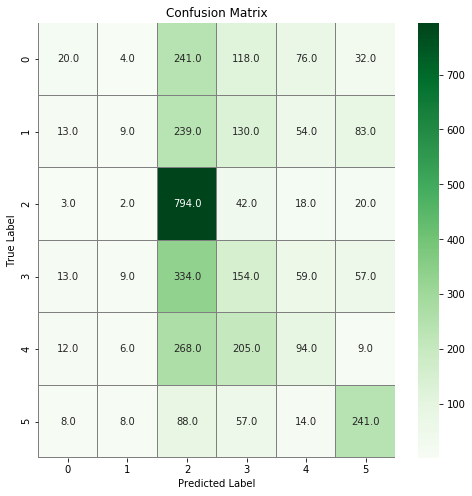

In [56]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cnf_matrix, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

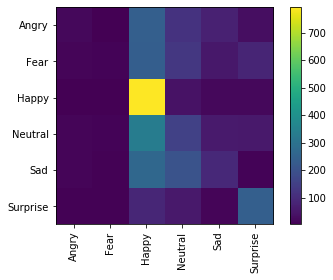

In [57]:
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)